**Лабораторный практикум по курсу «Распознавание диктора», Университет ИТМО, 2021**		

**Лабораторная работа №2. Обучение детектора речевой активности**

**Цель работы:** изучение процедуры построения энергетического детектора речевой активности на основе модели гауссовых смесей.

**Краткое описание:** в рамках настоящей лабораторной работы предлагается изучить и реализовать энергетический детектор речевой активности на основе модели гауссовых смесей; реализация детектора предполагает субъективную и объективную оценку его качества по целевым метрикам; тестирование детектора выполняется в идеализированных условиях, а также при наличии шумов и помех.

**Данные:** в качестве данных для выполнения лабораторной работы предлагается использовать тестовую часть базы [VoxCeleb1](http://www.robots.ox.ac.uk/~vgg/data/voxceleb/vox1.html).

**Содержание лабораторной работы**

1. Подготовка данных для обучения и тестирования детектора речевой активности.							

2. Изучение файлового формата RTTM.

3. Реализация энергетического детектора речевой активности на основе модели гауссовых смесей.

4. Коррекция разметки детектора речевой активности с использованием методов морфологической обработки.

5. Тестирование реализованного детектора речевой активности на «чистых» данных.

6. Тестирование реализованного детектора речевой активности на искажённых данных.

In [1]:
# IPython extension to reload modules before executing user code
%load_ext autoreload
%autoreload 2

# Import of modules
import os
import sys

sys.path.append(os.path.realpath('..'))

from math import sqrt, pi

import numpy as np
from matplotlib.pyplot import figure, plot, show, grid, title, xlabel, ylabel, legend, hist

from skimage.morphology import opening, closing
from torchaudio.transforms import Resample
import torchaudio

from common import download_dataset, extract_dataset
# from exercises_blank import load_vad_markup, framing, frame_energy, norm_energy, gmm_train, eval_frame_post_prob, energy_gmm_vad, reverb, awgn

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



**1. Подготовка данных для обучения и тестирования детектора речевой активности**

В ходе выполнения лабораторной работы необходимы данные для выполнения процедуры обучения и процедуры тестирования реализуемого детектора речевой активности. Возьмём в качестве этих данных несколько звукозаписей голосов людей мужского и женского пола, сохраненных в формат *wav*, выбранных из корпуса [VoxCeleb1 test set](https://thor.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox1_test_wav.zip). Данный корпус содержит 4,874 звукозаписи (частота дискретизации равна 16кГц) 40 дикторов мужского и женского пола, разговаривающих на английском языке.

В рамках настоящего пункта требуется выполнить загрузку и распаковку звуковых wav-файлов из корпуса VoxCeleb1 test set.

![Рисунок 1](https://analyticsindiamag.com/wp-content/uploads/2020/12/image.png "VoxCeleb. Крупномасштабная аудиовизуальная база данных человеческой речи.")

In [2]:
# # Download VoxCeleb1 (test set)
# with open('../data/lists/datasets.txt', 'r') as f:
#     lines = f.readlines()

# download_dataset(lines, user='voxceleb1902', password='nx0bl2v2', save_path='../data')

In [3]:
# Extract VoxCeleb1 test set
# extract_dataset(save_path='../data/voxceleb1_test', fname='../data/vox1_test_wav.zip')

**2. Изучение файлового формата RTTM**

*Файлы расширенной транскрипции с метками времени* (RTTM, rich transcription time marked) представляют собой текстовые файлы, в каждой строке которых содержатся разделённые пробелом метаданные, привязанных к звукозаписи объектов. Метаданные аннотируют отдельные элементы звукозаписи. Каждая строка [rttm-файла](./docs/rt09_meeting_eval_plan_v2.pdf) представляет аннотацию одного примера объекта. Типы объектов, привязанных к звукозаписи, варьируются по отношению к решаемой задачи. Так, например, при решении задачи *диаризации* разметка rttm-файла может содержать в каждой строке метаданные, связанные с одним из нескольких дикторов, разговаривающих в звукозаписи. Объектами в этом случае являются дикторы. В случае решения задачи построения детектора речевой активности разметка rttm-файла содержит в каждой строке метаданные, связанные с речевыми сегментами, присутствующими в звукозаписи. Объектом в этом случае является дикторская речь в целом.

Каждая строка rttm-файла содержит 10 полей. Из присутствующих в rttm-файле полей при выполнении настоящей лабораторной работы будут использоваться следующие: *поле 1*, тип объекта (SPEAKER, речь диктора), *поле 2*, имя файла без указания пути до него и расширения, *поле 3*, номер канала, с которым связан речевой сегмент, например, «1» или «2», *поле 4*, время начала речевого сегмента в секундах, *поле 5*, длительность речевого сегмента в секундах. *Поле 6*, *поле 7*, *поле 8*, *поле 9* и *поле 10* будут считаться неопределёнными. Возможный пример части rttm-файла для некоторой звукозаписи представлен ниже.

SPEAKER 00006 1 3.186 1.733 \<NA\> \<NA\> \<NA\> \<NA\> \<NA\>  
SPEAKER 00006 1 5.253 1.043 \<NA\> \<NA\> \<NA\> \<NA\> \<NA\>  
SPEAKER 00006 1 6.376 2.007 \<NA\> \<NA\> \<NA\> \<NA\> \<NA\>  
SPEAKER 00006 1 8.796 0.676 \<NA\> \<NA\> \<NA\> \<NA\> \<NA\>  

В рамках настоящего пункта предлагается проанализировать содержимое директория **./ground_truth/rttm/**, в котором представлены разметки идеального детектора речевой активности в rttm-формате, полученные путём ручной разметки для некоторых звукозаписей из базы данных VoxCeleb1 test set. Настоящие эталонные разметки предполагается использовать для оценки качества реального детектора речевой активности ниже в рамках рассматриваемой лабораторной работы. Отметим, что эталонные разметки звукозаписей на «речь» и «не речь» были получены с использованием [Wave Assistant](https://vk.com/wall-102309764) – программное обеспечение, позволяющее выполнять обработку речевых сигналов. Разметка детектора речевой активности в Wave Assistant может быть сохранена во внутренний seg-формат, из которого, путём несложной конвертации, разметка может быть представлена в rttm-формате.

Идеальные разметки из директория **./ground_truth/rttm/** получены для 20 звукозаписей (10 голосов дикторов женского пола и 10 голос дикторов мужского пола). Имена файлов идеальной разметки имеют следующий формат: **id10271_1gtz-CUIygI_00006.rttm**. В соответстввии со структурой данных базы VoxCeleb1 test set для примера выше это означает, что идеальная разметка, сформирована для звукозаписи **00006.wav**, выбраной из сессии **1gtz-CUIygI** и соответствущей диктору с идентификационным номером **id10271**. Если скачивание и распаковка данных базы VoxCeleb1 test set выполнены корректно в соответствии с пунктом 1 выше, то звукозапись, которой соответствует **./ground_truth/rttm/id10271_1gtz-CUIygI_00006.rttm** может быть найдена по следующему пути: **../data/voxceleb1_test/wav/id10271/1gtz-CUIygI/00006.wav**.

Ниже представлена последовательность действий, которую необходимо выполнить при рассмотрении настоящего пункта:

1. Загрузить и визуализировать осциллограмму любой звукозаписи, идеальная разметка детектора речевой активности которой находится в директории **./ground_truth/rttm/**.

2. Прочитать с использованием функционала базового ядра Python rttm-файл для загруженной звукозаписи.

3. Наложить разметку детектора речевой активности на осциллограмму визуализированной звукозаписи.

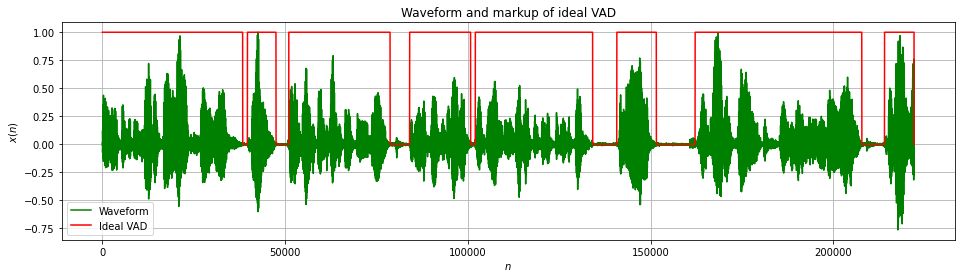

In [4]:
# Path to files
from exercises_blank import load_vad_markup
path_to_wav  = '../data/voxceleb1_test/wav/id10271/1gtz-CUIygI/00006.wav'
path_to_rttm = './ground_truth/rttm/id10271_1gtz-CUIygI_00006.rttm'

# Load signal
signal, fs = torchaudio.load(path_to_wav)
signal = signal.numpy().squeeze(axis=0)
signal = signal/np.abs(signal).max()

# Load ideal VAD's markup
vad_markup_ideal = load_vad_markup(path_to_rttm, signal, fs)

# Plot signal
figure(figsize=(16, 4))
plot(signal, color='green')
plot(vad_markup_ideal, color='red')
xlabel('$n$'); ylabel('$x(n)$'); title('Waveform and markup of ideal VAD'); grid(); legend(['Waveform', 'Ideal VAD']); show()

**3. Реализация энергетического детектора речевой активности на основе модели гауссовых смесей**

*Детектор речевой активности* предназначен для определения присутствия или отсутсвия речи в звукозаписи. Входом детектора является обрабатываемый сигнал, а выходом – разметка на «речь» и «не речь». Представить разметку детектора речевой активности можно различными способами, например, с использованием rttm-файла, путём визуализации в виде последовательности прямоугольных импульсов переменной длительности, наложенных на осциллограмму обрабатываемого сигнала во временной области и т.п. В последнем случае речевые участки обычно маркируется уровнем «1», а неречевые участки – уровнем «0».

На данный момент времени существует множество различных реализаций детекторов речевой активности, в том числе современных, основанных на использовании теории *глубоких нейронных сетей*. Необходимо отметить, что использование детекторов речевой активности является важным при решении задачи *распознавания диктора*, поскольку качество дикторских моделей, формируемых на основе речевых сигналов без длительных пауз, получается значительно лучше. В рамках настоящей лабораторной работы предлагается реализовать *энергетический детектор речевой активности* на основе *модели гауссовых смесей*.

Алгоритм реализации указанного энергетического детектор речевой активности и, фактически, последовательность действий, которую необходимо выполнить в рамках настоящего пункта, представлены ниже:

1. Загрузить речевой сигнал, разметку на «речь» и «не речь» которого необходимо получить.

2. Разбить обрабатываемый речевой сигнал с использованием некоторой оконной функции, например, прямоугольной, на перекрывающиеся сегменты (фреймы или кадры).

3. Вычислить для каждого из сегментов энергию сигнала. Предположив, что длина оконной функции составляет $L$ отсчётов, энергия сигнала в окне может быть вычислена с использованием следующего выражения: 

$$E(i)=\sum_{n = 0}^{L - 1}\left | x(n + i)w(n))) \right |^2,$$

где $x(n)$ – обрабатываемый речевой сигнал, $w(n)$ – оконная функция, а $i$ – шаг окна.

4. Выполнить нормализацию и масштабирование энергий сегментов на среднее значение и среднеквадратическое значение энергии, вычисленные по всем сегментам звукозаписи, получив признаки для обучения модели гауссовых смесей. Вычислить среднее значение и среднеквадратическое значение энергии по всем сегментам обрабатываемого сигнала можно с использованием следующих выражений:

$$m_E = \frac{1}{M}\sum_{i = 0}^{M - 1}E(i), \sigma_E = \sqrt{\frac{1}{M - 1}\sum_{i = 0}^{M - 1}(E(i) - m_E)^{2}},$$

здесь $M$ – количество сегментов, на которые был разбит сигнал. Нормализованные и масштабированные энергии сегментов можно определить следующим образом:

$$E_{norm}(i) = \frac{E(i) - m_E}{\sigma_E}.$$

5. Обучить модель гауссовых смесей для случая трёх одномерных гауссианов с использованием подготовленных выше признаков. В рассматриваемой задаче предполагается, что два из этих гауссианов порождают признаки, соответствующие речевым сегментам, а третий гауссиан порождает признаки, соответствующие неречевым сегментам. Обучение модели гауссовых смесей можно выполнить с использованием [EM-алгоритм](http://www.machinelearning.ru/wiki/index.php?title=EM-%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC), который, по своей сути, является вероятностным обобщением метода кластеризации на основе [k-средних](https://en.wikipedia.org/wiki/K-means_clustering).

Предположим, что одномерная модель гауссовых смесей из трёх гауссианов на множестве номированных энергий $E_{norm}$ описывается с использованием следующей плотности вероятностей:

$$W_{E_{norm}}(e)=\sum_{j = 0}^{2}w_jW_j(e), \sum_{j = 0}^{2}w_j = 1,$$

где $W_j(e)$ – функция правдоподобия $j$-й компонеты смеси, а $w_j$ – её априорная вероятность. Каждая компонента смеси может быть описана гауссовой плотностью вероятностей:

$$W_j(e) = N(e; m_j, \sigma_j) =\frac{1}{\sigma_j\sqrt{2\pi}}e^{\frac{-(e - m_j)^2}{2\sigma_j^2}},$$

где $m_j$ и $\sigma_j$ – это математическое ожидание и среднеквадратическое отклонение соответствующих компонент гауссовой смеси, а $j = 0, 1, 2$.

*E-шаг* алгоритма обучения модели гауссовых смесей можно описать так:

$$g_{ij} = \frac{w_jN(E_{norm}(i); m_j, \sigma_j)}{\sum_{s = 0}^{2}w_sN(E_{norm}(i); m_s, \sigma_s)}.$$

*M-шаг* алгоритма обучения модели гауссовых смесей можно описать с использованием следующих выражений:

$$w_j = \frac{1}{M}\sum_{i = 0}^{M - 1}g_{ij}, m_j = \frac{1}{Mw_j}\sum_{i = 0}^{M - 1}g_{ij}E_{norm}(i), \sigma_j = \sqrt{\frac{1}{Mw_j}\sum_{i = 0}^{M - 1}g_{ij}(E_{norm}(i) - m_j)^2},$$

здесь $M$ – количество сегментов, на которые был разбит сигнал.

6. С использованием обученной модели оценить принадлежность сегмента к «не речи». В предположении, что значения энергий неречевых сегментов порождаются гауссианом с индексом «0» оценим апостериорные вероятности того, что объект $E_{norm}(i)$ получен из 0-й компоненты смеси:

$$\hat{g}_{i0} = \frac{\hat{w}_0N(E_{norm}(i); \hat{m}_0, \hat{\sigma}_0)}{\sum_{s = 0}^{2}\hat{w}_sN(E_{norm}(i); \hat{m}_s, \hat{\sigma}_s)},$$

здесь $\hat{w}_j$, $\hat{m}_j$ и $\hat{\sigma}_j$ являются обученными параметрами модели гауссовых смесей. Чем выше $\hat{g}_{i0}$ для выбранного значения $E_{norm}(i)$, тем наиболее вероятно, что соответствующий фрейм относится к неречевому.

7. Подобрать порог принятия решения для детектора речевой активности.

8. Сформировать пофреймовую разметку детектора речевой активности на «речь» и «не речь», маркируя речевые фреймы символом «1»,а не речевые – символом «0». Выполнить данную процедуру можно путём сравнения величины $\hat{g}_{i0}$ для выбранного значения $E_{norm}(i)$ с заданным порогом детектора. Если величина $\hat{g}_{i0}$ находится ниже порога, то сегмент предполагается речевым, в противном случае – неречевым. В случае необходимости пофреймовая разметка детектора речевой активности может быть преобразована в разметку по отсчётам сигнала. Последнее позволит, например, визуально сравнить реальную и эталонную разметки детектора путём их наложения на осциллограмму обрабатываемой звукозаписи.

In [5]:
# Squared signal
squared_signal = signal**2

In [6]:
# Frame signal with overlap
from exercises_blank import framing
window = 320 # window size in samples
shift  = 160 # window shift in samples
frames = framing(squared_signal, window=window, shift=shift)

In [7]:
# Sum frames to get energy
from exercises_blank import frame_energy
E = frame_energy(frames)

In [8]:
frames.shape

(1387, 320)

In [9]:
E.shape

(1387,)

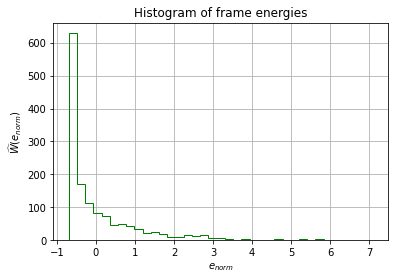

In [10]:
# Normalize the energy
from exercises_blank import norm_energy
E_norm = norm_energy(E)

# Plot histograms for frame energies
hist(E_norm, int(sqrt(len(E_norm))), histtype='step', color='green')
xlabel('$e_{norm}$'); ylabel('$\widehat{W}(e_{norm})$'); title('Histogram of frame energies'); grid(); show()

In [11]:
# Gaussian probability density function
gauss_pdf = lambda value, m, sigma: 1/((abs(sigma) + 1e-10)*sqrt(2*pi))*np.exp(-(value - m)**2/(2*(abs(sigma) + 1e-10)**2))

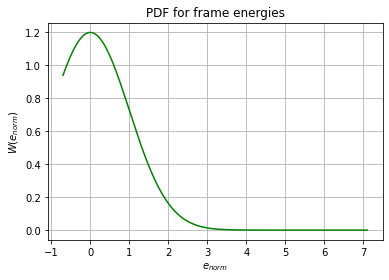

In [12]:
# Train parameters of gaussian mixture models

from exercises_blank import gmm_train
w, m, sigma = gmm_train(E_norm, gauss_pdf, n_realignment=10)

GMM_pdf = np.zeros(len(E_norm))
for j in range(len(m)):
    GMM_pdf = GMM_pdf + gauss_pdf(sorted(E_norm), m[j], sigma[j])
    
# Plot PDF for frame energies
plot(sorted(E_norm), GMM_pdf, color='green')
xlabel('$e_{norm}$'); ylabel('$W(e_{norm})$'); title('PDF for frame energies'); grid(); show()

In [13]:
# Estimate a posterior probability that frame isn't speech
from exercises_blank import eval_frame_post_prob
g0 = eval_frame_post_prob(E_norm, gauss_pdf, w, m, sigma)

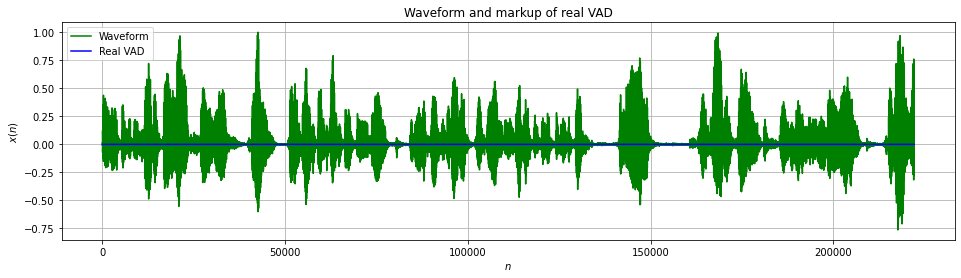

In [14]:
# Compute real VAD's markup
vad_thr = 0.3 # threshold of voice activity detector

vad_frame_markup_real = (g0 < vad_thr).astype('float32')  # frame VAD's markup

vad_markup_real = np.zeros(len(signal)).astype('float32') # sample VAD's markup
for idx in range(len(vad_frame_markup_real)):
    vad_markup_real[idx*shift:shift+idx*shift] = vad_frame_markup_real[idx]

vad_markup_real[len(vad_frame_markup_real)*shift - len(vad_markup_ideal):] = vad_frame_markup_real[-1]

# Plot signal
figure(figsize=(16, 4))
plot(signal, color='green')
plot(vad_markup_real, color='blue')
xlabel('$n$'); ylabel('$x(n)$'); title('Waveform and markup of real VAD'); grid(); legend(['Waveform', 'Real VAD']); show()

**4. Коррекция разметки детектора речевой активности с использованием методов морфологической обработки**

Анализ разметки, полученной с использованием детектора речевой активности выше показывает, что она сильно отличается от эталонной разметки высокой частотой нарезки звукозаписи на речевые сегменты. Попытаться сделать разметку детектора менее частой, в случае необходимости, можно с использованием методов [морфологической фильтрации](http://www.theobjects.com/dragonfly/dfhelp/4-0/Content/05_Image%20Processing/Morphology%20Filters.htm), применяемых в ранних системах обработки цифровых изображений, в первую очередь *бинарных*, состоящих только из пикселей двух уровней яркости. Фактически, разметку детектора речевой активности можно рассматривать в качестве одной строки или столбца бинарного цифрового изображения. Поэтому с использованием некоторой одномерной бинарной маски *морфологического фильтра*, называемой *структурирующим элементом*, разметка детектора речевой активности может быть отфильтрована.

Ключевыми процедурами *морфологической обработки* являются следующие:

1. *Наращивание (dilate)* – процедура морфологичекой фильтрации, позволяющая увеличить область цифрового изображения.
2. *Эрозия (erode)* – процедура морфологичекой фильтрации, позволяющая уменьшить область цифрового изображения.
3. *Замыкание (close)* – процедура морфологичекой фильтрации, представляющая последовательное использование наращивания и эрозии.
4. *Размыкание (open)* – процедура морфологичекой фильтрации, представляющая последовательное использование эрозии и наращивания.

В рамках настоящего пункта предлагается провести эксперименты с процедурами замыкания и размыкания применительно к полученной выше разметке детектора речевой активности.

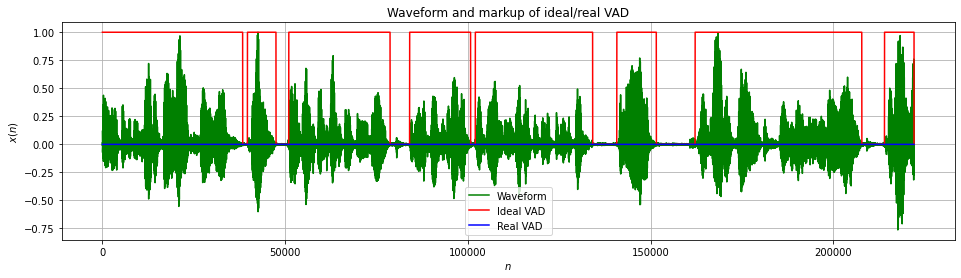

In [15]:
# Morphology Filters
mask_size = 6000 # size of filter's mask

# Close filter
vad_markup_real_filt = closing(vad_markup_real, np.ones(mask_size))

# Open filter
vad_markup_real_filt = opening(vad_markup_real_filt, np.ones(mask_size))

# Plot signal
figure(figsize=(16, 4))
plot(signal, color='green')
plot(vad_markup_ideal, color='red')
plot(vad_markup_real_filt, color='blue')
xlabel('$n$'); ylabel('$x(n)$'); title('Waveform and markup of ideal/real VAD'); grid(); legend(['Waveform', 'Ideal VAD', 'Real VAD']); show()

**5. Тестирование реализованного детектора речевой активности на «чистых» данных**

Визульная оценка качества работы детектора речевой активности является нагдядной, но не даёт глобального понимания того, насколько хорошо работает детектор речевой активности «глобально» в рамках некоторого кейса и не позволяет эффективно сравнить работу одного детектора с другим. Для решения указанной проблемы требуется использовать объективные метрики оценки качества. Поскольку результатом детектора речевой активности является разделение сигнала на участки двух типов, «речь» и «не речь», то для численной оченки качества в данном случае подойдут метрики, используемые в бинарной теории принятия решений. К ним можно отнести *вероятности ошибок первого (FRR, false rejection rate, или FNR, false negative rate)* и *второго рода (FAR, false acceptance rate, или FPR, false positive rate)*, *точность (P, precision)* и *полнота выборки (R, recall)*, *равный уровень ошибок (EER, equal error rate)* и т.п. Идеи реализаций некоторых из указанных метрик, применительно к оценке качества результатов бинарной сегментации цифровых изображений, могут быть найдены по следующей [ссылке](https://github.com/DeepTrial/AutoMetric/blob/master/autoMetric.py).

В рамках настоящего пункта требуется вычислить вероятности ошибок первого и второго рода, а также точность и полноту выборки для фиксированного значения порога детектора речевой активности. При вычислении метрик предположим, что *нулевой гипотезой* является наличие речи, а альтернативной – отсутствие речи в некотором сегменте обрабатываемого сигнала. В качестве данных для оенки качества детектора речевой активности воспользуемся 20 звукозаписями, разметка идеального детектора которых представлена в директории **./ground_truth/rttm/**. 

In [16]:
# Parameters of voice activity detector
from exercises_blank import energy_gmm_vad
window = 320
shift  = 160
n_realignment = 10
vad_thr = 0.3
mask_size_morph_filt = 6000

# Gaussian probability density function
gauss_pdf = lambda value, m, sigma: 1/((abs(sigma) + 1e-10)*sqrt(2*pi))*np.exp(-(value - m)**2/(2*(abs(sigma) + 1e-10)**2))

# Path to files
path_to_wav  = '../data/voxceleb1_test/wav'
path_to_rttm = './ground_truth/rttm'

TP, FP, FN, TN = 0.0, 0.0, 0.0, 0.0

for rttm_file in os.listdir(path_to_rttm):
    # Load signal
    signal, fs = torchaudio.load(os.path.join(path_to_wav, rttm_file[:7], rttm_file[8:19], '.'.join([rttm_file[20:25], 'wav'])))
    signal = signal.numpy().squeeze(axis=0)
    signal = signal/np.abs(signal).max()

    # Load ideal VAD's markup
    vad_markup_ideal = load_vad_markup(os.path.join(path_to_rttm, rttm_file), signal, fs)
    
    # Compute real VAD's markup
    vad_markup_real = energy_gmm_vad(signal, window, shift, gauss_pdf, n_realignment, vad_thr, mask_size_morph_filt)
    
    TP = TP + np.sum(vad_markup_ideal*vad_markup_real)
    FP = FP + np.sum((1 - vad_markup_ideal)*vad_markup_real)
    FN = FN + np.sum(vad_markup_ideal*(1 - vad_markup_real))
    TN = TN + np.sum((1 - vad_markup_ideal)*(1 - vad_markup_real))

FNR = FN/(FN + TP) # false negative  rate
FPR = FP/(FP + TN) # false positive rate
P   = TP/(TP + FP) # precision
R   = TP/(TP + FN) # recall

print('Threshold value:      {0:.3f}'.format(vad_thr))
print('False negative rate:  {0:.3f}'.format(FNR))
print('False positive rate:  {0:.3f}'.format(FPR))
print('Precision:            {0:.3f}'.format(P))
print('Recall:               {0:.3f}'.format(R))

Threshold value:      0.300
False negative rate:  1.000
False positive rate:  0.000
Precision:            nan
Recall:               0.000


/tmp/ipykernel_8906/2223701854.py:37: RuntimeWarning: invalid value encountered in double_scalars
  P   = TP/(TP + FP) # precision


**6. Тестирование реализованного детектора речевой активности на искажённых данных**

Процедуры формирования и передачи речевого сигнала могут сопровождаться воздействием шумов и помех, приводящих к искажению сигнала. В качестве примеров искажающих факторов, влияющих на ухудшение качестве речевого сигнала можно привести: импульсный отклик помещения (реверберация), фоновый шум голосов группы нецелевых дикторов, звук телевизора или радиоприёмника и т.п. Разработка конвейера системы голосовой биометрии требует учёта воздействия искажающих факторов на качество работы отдельных блоков и всей системы в целом. Поскольку отдельные этапы современных систем голосовой биометрии реализуются с использованием глубоких нейронных сетей, требующих большие объёмы данных для обучения, то возможным вариантом учёта искажений, воздействующих на систему, может являться расширение тренировочной выборки для обучения моделей за счёт методов аугментации. *Аугментация* – методика создания дополнительных обучающих примеров из имеющихся данных. Как правило, при решении задачи аугментации данных в речевой обработке используются дополнительные базы шумов и помех. В качестве примеров можно привести базы [SLR17](https://openslr.org/17/) (корпус музыкальных, речевых и шумовых звукозаписей) и [SLR28](https://openslr.org/28/) (база данных реальных и симулированных импульсных откликов комнат, а также изотропных и точечных шумов).

Рассмотрим в рамках настоящего пункта техники аугментации, моделирующие воздествие *реверберации* и *аддитивного белого гауссовского шума (АБГШ)* на речевой сигнал и проанализируем их влияние на качество работы детектора речевой активности. В рамках настоящего пункта требуется:

1. Промоделировать эффект реверберации для некоторого записанного импульсного отклика помещения с использованием *линейного инвариантного к сдвигу фильтра*. При моделировании эффекта реверберации предлагается воспользоваться импульсным откликом [Лозаннского собора](https://en.wikipedia.org/wiki/Lausanne_Cathedral), который измерили Докманич И. и его коллеги, записавшие звук лопнувшего в соборе воздушного шарика. 

2. Промоделировать воздействие аддитивного шума с использованием модели АБГШ для различных уровней мощности шума.

3. Выполнить тестирование детектора речевой активности при наличии реверберации или АБГШ с использованием описанных выше численных метрик оценки качества.

In [17]:
# Parameters of voice activity detector

from exercises_blank import reverb, awgn

window = 320
shift  = 160
n_realignment = 10
vad_thr = 0.3
mask_size_morph_filt = 6000

# Gaussian probability density function
gauss_pdf = lambda value, m, sigma: 1/((abs(sigma) + 1e-10)*sqrt(2*pi))*np.exp(-(value - m)**2/(2*(abs(sigma) + 1e-10)**2))

# Path to files
path_to_wav  = '../data/voxceleb1_test/wav'
path_to_rttm = './ground_truth/rttm'

aug_mode = 'reverb' # augmentation mode ('reverb' or 'awgn')

TP, FP, FN, TN = 0.0, 0.0, 0.0, 0.0

for rttm_file in os.listdir(path_to_rttm):
    # Load signal
    signal, fs = torchaudio.load(os.path.join(path_to_wav, rttm_file[:7], rttm_file[8:19], '.'.join([rttm_file[20:25], 'wav'])))
    signal = signal.numpy().squeeze(axis=0)
    signal = signal/np.abs(signal).max()
    
    if aug_mode == 'awgn':
        impulse_response, ir_fs = torchaudio.load('./cathIR.wav')
        
        resample = Resample(orig_freq=ir_fs, new_freq=fs, resampling_method='sinc_interpolation')
        
        impulse_response = resample(impulse_response)
        impulse_response = impulse_response.numpy().squeeze(axis=0)
        impulse_response = impulse_response/np.abs(impulse_response).max()

        signal = reverb(signal, impulse_response)
        
    else:
        sigma_noise = 0.15
        signal = awgn(signal, sigma_noise)

    # Load ideal VAD's markup
    vad_markup_ideal = load_vad_markup(os.path.join(path_to_rttm, rttm_file), signal, fs)
    
    # Compute real VAD's markup
    vad_markup_real = energy_gmm_vad(signal, window, shift, gauss_pdf, n_realignment, vad_thr, mask_size_morph_filt)
    
    TP = TP + np.sum(vad_markup_ideal*vad_markup_real)
    FP = FP + np.sum((1 - vad_markup_ideal)*vad_markup_real)
    FN = FN + np.sum(vad_markup_ideal*(1 - vad_markup_real))
    TN = TN + np.sum((1 - vad_markup_ideal)*(1 - vad_markup_real))
    
FNR = FN/(FN + TP) # false negative  rate
FPR = FP/(FP + TN) # false positive rate
P   = TP/(TP + FP) # precision
R   = TP/(TP + FN) # recall

print('Threshold value:      {0:.3f}'.format(vad_thr))
print('False negative rate:  {0:.3f}'.format(FNR))
print('False positive rate:  {0:.3f}'.format(FPR))
print('Precision:            {0:.3f}'.format(P))
print('Recall:               {0:.3f}'.format(R))

Threshold value:      0.300
False negative rate:  1.000
False positive rate:  0.000
Precision:            nan
Recall:               0.000


/tmp/ipykernel_8906/3936452749.py:56: RuntimeWarning: invalid value encountered in double_scalars
  P   = TP/(TP + FP) # precision


**7. Контрольные вопросы**

1. Как устроен rttm-файл и для каких целей он используется?
2. Как вычислить энергию сигнала?
3. Что такое модель гауссовых смесей?
4. Что такое детектор речевой активности?
5. Как устроен энергетический детектор речевой активности на основе модели гауссовых смесей?
6. Основные достоинства и недостатки энергетического детектора речевой активности.
7. В чём идея использования методов морфологической обработки в коррекции разметки детектора речевой активности?
8. Какие численные метрики оценки качества можно использовать для описания результата работы детектора речевой активности?
9. Что такое аугментация данных и для каких целей она используется?
10. Как можно построить более совершенный, чем энергетический, детектор речевой активности?

**8. Список литературы**

1. Bishop C.M. Pattern recognition and machine learning. Springer, 2006 ([ссылка](http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf)).
2. Beigi H. Fundamentals of speaker recogniton. Springer, 2011 ([ссылка](https://www.springer.com/gp/book/9780387775913)).
3. Černocký H. Voice biometry standard proposal // Interspeech 2015, Dresden, Germany, 2015 ([ссылка](https://voicebiometry.org/)).